In [1]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create path to data directory, make sure it exists
data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"Data")
assert os.path.isdir

In [3]:
# Define paths to image file and shape files + make sure it exists
imgf = os.path.join(data_dir, "PDX_DEM_WGS84_UTM10N_Zm_INT16.tif")
assert os.path.isfile(imgf)

### Opening and Closing files with Rasterio

In [6]:
# Two ways of opening files -- same as fiona
with rasterio.open(imgf,'r') as src:
    print(src.profile)

print(src)  # File is closed when code block is complete

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 6161, 'height': 3951, 'count': 1, 'crs': CRS.from_dict(init='epsg:32610'), 'transform': Affine(10.0, 0.0, 490893.2197361471,
       0.0, -10.0, 5054008.957242726), 'tiled': False, 'interleave': 'band'}
<closed DatasetReader name='D:\Zach_Working\02_Scratch\PUG\HilliestBusRoute\Data\PDX_DEM_WGS84_UTM10N_Zm_INT16.tif' mode='r'>


In [10]:
src = rasterio.open(imgf, 'r')

print(src.profile)
print(src) # File is still open

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 6161, 'height': 3951, 'count': 1, 'crs': CRS.from_dict(init='epsg:32610'), 'transform': Affine(10.0, 0.0, 490893.2197361471,
       0.0, -10.0, 5054008.957242726), 'tiled': False, 'interleave': 'band'}
<open DatasetReader name='D:\Zach_Working\02_Scratch\PUG\HilliestBusRoute\Data\PDX_DEM_WGS84_UTM10N_Zm_INT16.tif' mode='r'>


In [11]:
# Close the file
src.close()
print(src)

<closed DatasetReader name='D:\Zach_Working\02_Scratch\PUG\HilliestBusRoute\Data\PDX_DEM_WGS84_UTM10N_Zm_INT16.tif' mode='r'>


### Getting Raster Metadata from file

In [13]:
# Open the dataset
src = rasterio.open(imgf, 'r')

In [24]:
# Get GeoTransform
# GeoTransform is slightly different with rasterio than it was for the gdal 
# library. Calling the "transform" attribute on the raster dataset returns an
# an instance of a class that has 'methods'
#
# First: you can index rasterios geotransform the same way that you could 
# gdal's, except the data will be in a different order.
# 0  X pixel Width 
# 1  X pixel rotation (0 degrees if north up)
# 2  X Origin Coord
# 3  Y pixel rotation (0 degrees if north up) 
# 4  Y pixel Height (negative)
# 5  Y Origin Coord

# in the following order (dx, rx, ulx, ry, dy, uly)
src.transform







Affine(10.0, 0.0, 490893.2197361471,
       0.0, -10.0, 5054008.957242726)

In [25]:
# However, you can do fun things with rasterio's geotransform attribute:

# You can calculate the spatial coordinates of any pixels upper left corner
# by multiplying the transform by (pixel column, pixel row).
src.transform * (50,50)


(491393.2197361471, 5053508.957242726)

In [26]:
# You can back calculate which pixel contains a spatial location by 
# multiplying the spatial location by the inverse of the transform
~src.transform * (491393.2197361471, 5053508.957242726)

(50.0, 50.0)

In [27]:
# You can also convert rasterio's geotransform format to gdals:
src.transform.to_gdal()

(490893.2197361471, 10.0, 0.0, 5054008.957242726, 0.0, -10.0)

In [28]:
# Getting projection information
src.crs

CRS.from_dict(init='epsg:32610')

In [35]:
# Get the EPSG Code
src.crs.to_epsg()

32610

In [36]:
# Get Projection as well known text/esri
src.crs.to_wkt()

'PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]'

In [39]:
# Get Shape information
src.shape

(3951, 6161)

In [45]:
# Get band count
src.indexes[0]

1

### Reading Data to Arrays

In [46]:
# Read a single band into memory
band = src.read(1)

In [53]:
band.shape

(3951, 6161)

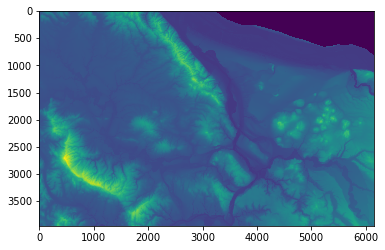

In [48]:
plt.imshow(band)
plt.show()

In [51]:
# Read a "window" of a single band into memory
# the read method of the src object ("dataset") takes an instance 
# of the "Window" class  Window(xoff,yoff,xsize,ysize) with the offset
# and size variables for x and y being in pixel counts  


# The window class needs to be imported before it can be directly referenced
from rasterio.windows import Window

In [52]:
# Lets read the first 100 pixels of the array from the upper left corner
xoff, yoff = (0, 0)
xsize, ysize = (100, 100)

subset = src.read(1, window=Window(xoff, yoff, xsize, ysize))

In [54]:
subset.shape

(100, 100)

### Sidebar to talk about interpolation in matplotlib

In [132]:
# Lets pick mount tabor as a location, and use the geotransform to calculate 
# the col/row start point in the raster

#Mt Tabor Location
# Find top of Mt. Tabor in Google Earth


x, y  = (531700, 5040100)
col, row = ~src.transform * (x, y)
mini = src.read(1, window=Window(col, row,  15, 15))

mini.shape

(15, 15)

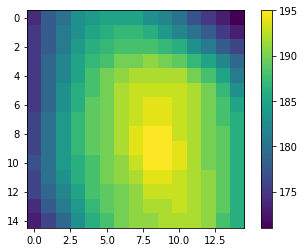

In [137]:
plt.imshow(mini,interpolation='none')
plt.colorbar()
plt.show()

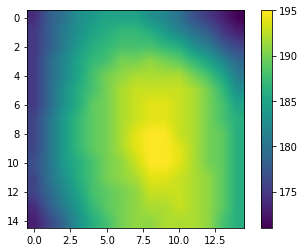

In [138]:
plt.imshow(mini,interpolation='bilinear')
plt.colorbar()
plt.show()

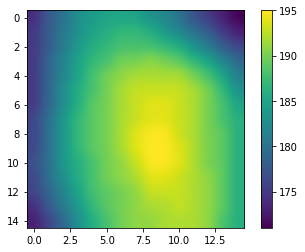

In [139]:
plt.imshow(mini,interpolation='gaussian')
plt.colorbar()
plt.show()

### Masking

In [140]:
# Sometimes you need to "mask" or remove data from an array before you
# analyze the data in the array.  Why might this be?

In [142]:
# Lets create a mask
# Say the sea level is rising, and we are all near mount tabor. we want to know
# how much of mount tabor will be above sea level if the sea level
# rises to 185m ASL

In [143]:
# We can reuse the variable "mini" from above, which represents mt. tabor
mask = mini > 185

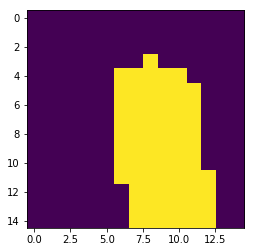

In [148]:
plt.imshow(mask)
plt.show()

In [145]:
# Cool but how much area is that?
# Well, we know from the geotransform each pixel represents 10x10m, so one 
# pixel is 100 sq m.

In [146]:
# to find the area of the pixels, add up the number of pixels that are 
# greater than 185, and multiply by 100
np.sum(mini>185) * 100

14300

In [147]:
#What if the sea level rose to 190 m
np.sum(mini > 190) * 100

6700